# __<center> Projet Maths-Info #1 : Lignes de niveau</center>__

Binôme: Julien LAVAL et Nathan LINÉ.

Ce notebook développe un programme Python pour le calcul de lignes de niveau d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$, qui est supposée $\mathcal{C}^1$.

Tout d'abord, on importe les librairies Python dont on aura besoin :

In [47]:
import autograd 
from autograd import numpy as np
import matplotlib.pyplot as plt

#### Fonctions de test :

Pour tester les différents algorithmes de ce notebook, on définit dès lors deux fonctions test de $\mathbb{R}^2$ dans $\mathbb{R}$ :

In [48]:
def quad(x,y):
    #Fonction quadratique
    return x**2+y**2

def l(x,y):
    # Fonction utilisée pour la démo de la fonction contour de matplotlib
    return 2*(np.exp(-x**2 -y**2) - np.exp(-(x-1)**2-(y-1)**2))
           

### Contour simple :

Dans un premier temps, on suppose $f: [0,1]^2 \to \mathbb{R}$, et on cherche des lignes de niveau qui ont un point sur l'arête gauche.

#### **Amorce :**

$\triangleright$ Condition pour avoir un point sur l'arête gauche:  
Soit $c \in \mathbb{R}$, valeur de la ligne de niveau. 

$f$ est $\mathcal{C}^1$, donc séparément continue : $t \mapsto f(0,t)$ est $\mathcal{C}^0$.  
Ainsi, si $c$ est dans le segment formé par $f(0,0)$ et $f(0,1)$, il existe par TVI $ t \in [0,1]$ tel que $f(0,t) = c$.  
Cette condition se réécrit $(f(0,0) - c)(f(0,1) -c) \leq 0$, forme plus manipulable en pratique ( car pas besoin de tester d'inégalité entre $f(0,0)$ et $f(0,1)$).

$\underline{Remarque:}$ Cette condition est *suffisante*, mais évidemment pas *nécessaire*. Elle restreint donc trop grandement la classe de fonction traitée.


$\triangleright$ Pour plus de lisibilité, on définit $h : [0,1] \to \mathbb{R}, \; t  \mapsto f(0,t) - c$ : la condition devient $h(0).h(1) \leq 0$.  
On code alors la fonction *find_seed*:

In [49]:
def find_seed(f, c=0, eps= 2**(-26)):
    # Dichotomie sur la taille de l'intervalle pour trouver le réel en question.
    # La taille de l'intervalle étant divisée par 2 à chaque itération de la boucle while, la terminaison est assurée.
    def h(t):
        return (f(0,t) -c)
    if h(0) * h(1) > 0:
        return None
    i,j = 0,1
    while (j-i)>eps:
        t = (i+j)/2
        if h(i)*h(t)<=0:
            j = t
        else:
            i = t
    return i


# Vérification : 
# c = 1/4, avec la fonction quad, la valeur théorique est t = 1/2.

find_seed(quad, c = 1/4)
abs(find_seed(quad, c = 1/4)-1/2)<=2**(-26) 

True

#### Propagation :

**Méthode #1: Gradient**

Pour une fonction $f : \mathbb{R}^2 \to \mathbb{R}$ différentiable, la relation $df = \vec{\text{grad}}(f) \cdot \vec{dl}$ implique que le gradient de $f$ est perpendiculaire aux lignes de niveau.  
On peut donc procéder ainsi :
* On trouve un point de la ligne de niveau sur l'arête gauche avec *find_seed*.
* On calcule ensuite son gradient, puis la droite perpendiculaire à ce gradient passant par ce point : elle approxime localement la ligne de niveau.
* Avec un pas suffisament faible, on suit cette ligne pour trouver le prochain point, puis on recommence.

$\diamond$ Problèmes :
* Le pas doit être suffisament faible pour que l'approximation soit légitime.
* En suivant la droite, il existe deux directions possibles : il faut *faire un choix*, et éviter de revenir sur ses pas / de boucler.       

$\diamond$ Hypothèse gradient :
  
On supposera que l'on applique notre algorithme en des points où le gradient de $f$ est non nul :  
en effet, s'il est nul, on ne peut pas tirer d'information de la relation $df = \vec{grad}(f) \cdot \vec{dl}$.  
  
  
En pratique, si le gradient de $f$ n'est nul que ponctuellement en des points de $]0,1[^2$, on peut changer le pas $\Delta$ pour les éviter.  
Cependant, on peut imaginer une ligne de niveau constituée d'extrema de la fonction, sur laquelle le gradient sera alors identiquement nul :  
la classe des fonctions traitées est encore restreinte. 
  


$\diamond$ Calculs : 
  
$\triangleright$ Soit $M_0 = (x_0,y_0)$ point de $\mathbb{R}^2$, qui est la valeur dont on part.  
On note $\vec{\text{grad}}(f)(M_0) = \begin{pmatrix}a\\b\end{pmatrix}$, noté $G$ dans la suite.  
Soit $\mathcal{D}$ la droite perpendiculaire à $G$ et passant par $M_0$.
\begin{array}{rcl}
M = (x,y) \in \mathcal{D}   & \Leftrightarrow & \vec{M_0M} \perp G \\
              & \Leftrightarrow & \begin{pmatrix}x-x_0 \\ y - y_0 \end{pmatrix} \cdot \begin{pmatrix}a\\b\end{pmatrix}  = 0\\ 
              & \Leftrightarrow & a\,(x-x_0) + b\,(y-y_0) =0\\
\end{array}  

$\triangleright$ On impose également un pas $\Delta$ entre les points, on a donc le système :  

\begin{array}{rl}
a\,(x-x_0) + b\,(y-y_0) =0 & (1) \\
(x-x_0)^2 + (y-y_0)^2 = \Delta^2 & (2)\\
\end{array}

$\bullet \, \underline{b = 0} : \, a \neq 0$ (par hypothèse $(a,b) \neq (0,0)$), et alors $(x,y) = (x_0, \,  y_0 \pm  \Delta) \quad \tiny{(\Delta \text{ positif})}$

$\bullet \, \underline{b \neq 0} : \, (2): \, (x-x_0)^2 (1+ (\dfrac{a}{b})^2) = \Delta^2$.  
$ \Rightarrow (x,y) = \left (x_0 \pm \dfrac{\Delta}{\sqrt{1+ (\frac{a}{b})^2}}, y_0 \mp \frac{a}{b} \dfrac{\Delta}{\sqrt{1+(\frac{a}{b})^2}} \right ) \quad \tiny{(\text{le } \pm \text{ et } \mp \text{ signifient que si l'on prend plus pour x, on prend moins pour y})}$.  
  
On se retrouve bien, comme prévu, avec deux couples solutions, donc deux directions possibles sur la droite.

$\diamond$ Choix du point :

La question du choix du point n'est pas simple. Une première idée était de prendre toujours le même couple solution parmi les deux, mais le risque était de boucler et que l'algorithme ne finisse pas.  

La solution que nous avons envisagée est de prendre, pour une itération de l'algorithme en un point $M_0$, le point le plus éloigné du point précédant $M_0$, afin de ne pas revenir vers les mêmes points.  Cela permet de s'assurer que l'on avance dans la ligne de niveau, et semble marcher pour les fonctions testées.
  
En pratique, cette méthode de choix permet à la fonction finale *contour* avec la méthode du gradient de terminer et de donner une solution, alors qu'un choix du type 'toujours le même couple solution' donne un algorithme qui ne termine pas, donc boucle probablement.


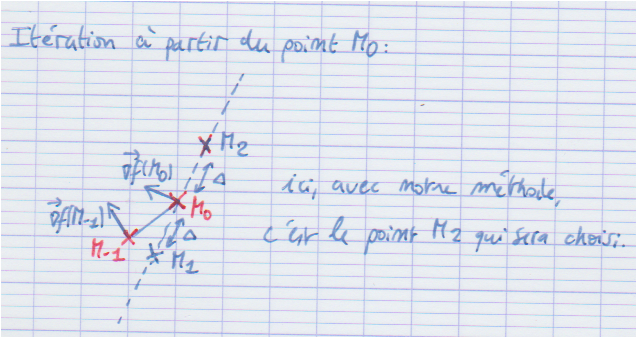

<center> Schéma de la méthode de choix </center>

On obtient l'algorithme :

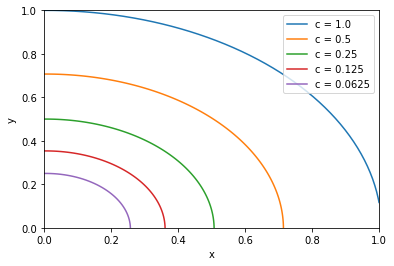

In [50]:
# fonction gradient : 
def grad(f,x,y):
    g = autograd.grad
    return np.r_[g(f,0)(x,y),g(f,1)(x,y)]

# Distance au carré pour comparer
def d(x,y,z,t):
    return (x-z)**2 + (y-t)**2

def simple_contour(f, c=0.0, delta = 0.01):
    x,y = [],[]
    if find_seed(f,c) != None:
        t = find_seed(f,c)
        x.append(0.0)
        y.append(t)
        [a,b] = grad(f,0.0,t)
        while (0 <= x[-1] <= 1) and (0 <= y[-1] <= 1):
            # On teste pour rester dans le carré
            x_0, y_0 = x[-1], y[-1]
            #On implémente exactement le calcul précédent, avec le choix du point.
            if b !=0:
                if len(x)>=2:
                    # Choix du point parmi les deux : on prend le point le plus éloigné du point précédent le point à partir
                    #duquel on calcule la tangeante.
                    xp, yp = x[-2],y[-2]
                    x1,x2 = x_0 + delta/np.sqrt((1 + (a/b)**2)), x_0 - delta/np.sqrt((1 + (a/b)**2))
                    y1,y2 = -a/b*(x1 - x_0) + y_0, -a/b*(x2 - x_0) + y_0
                    if d(x1,y1,xp,yp) >= d(x2,y2,xp,yp):
                        # test du point le plus proche
                        x.append(x1)
                        y.append(y1)
                    else:
                        x.append(x2)
                        y.append(y2)
                else:
                    x.append(x_0 + delta/np.sqrt((1 + (a/b)**2)))
                    y.append(-a/b*(x[-1] - x_0) + y_0)
            else:
                x.append(x_0)
                y.append(y_0 + delta)
            [a,b] = grad(f,x[-1],y[-1])
        return x,y
    return [],[]

# Test sur la fonction quadratique, sur [0,1]².
for i in range(5):
    x_i,y_i = simple_contour(quad, (1/2)**i)
    plt.plot(x_i,y_i, label = f"c = {(1/2)**i}")
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

$\diamond$ Remarque : Théorème des fonctions implicites  
  
Avec $f: [0,1]^2 \to \mathbb{R} \; \mathcal{C}^1$, et $(x_0,y_0)$ point de la ligne de niveau duquel on part, on note encore $\vec{grad}(f)(x_0,y_0) = (a,b)$.  
La recherche de ligne de niveau $f(x,y) = c$, $c \in \mathbb{R}$, est équivalente à une recherche de zéros en translatant $f$ de $c$ : on peut supposer $c = 0$.  
  
  
Selon le théorème des fonctions implicites,  
avec $f(x_0,y_0) = 0$, et un voisinage de $(x_0,y_0)$ sur lequel $\partial_yf$ est inversible,   
$ \exists \, \psi \; \mathcal{C}^1$ telle que $ f(x,y) = 0 \Leftrightarrow y = \psi(x)$ sur ce voisinage.  
De plus, $\psi'(x_0) = -(\partial_yf(x_0,y_0))^{-1} \partial_xf(x_0,y_0)  
             = -\dfrac{a}{b}$.

Ainsi, on peut localement écrire : $y = \psi(x) \simeq \psi'(x_0) (x-x_0) + \psi(x_0)$      
$ \hspace{117pt}  = - \dfrac{a}{b} (x-x_0) + y_0.$  
On retrouve l'équation $a(x-x_0) + b(y - y_0) = 0$ : la méthode est **équivalente**.
  


**Méthode #2: Dichotomie sur le cercle**

On considère toujours une fonction $f : [0,1]^2 \to \mathbb{R} \; \mathcal{C}^1$, et un pas $\Delta$ entre les points.  
L'algorithme suivant repose sur des dichotomies sur des cercles de rayon $\Delta$:
* On trouve un point de la ligne de niveau sur l'arête gauche, avec *find_seed*.
* On trace un cercle de rayon $\Delta$ autour du point, et on effectue une dichotomie sur le cercle afin de trouver le prochain point. La dichotomie est seulement effectuée sur une moitié du cercle, définie par la direction [voir schéma].
* On recommence jusqu'à sortir du cadre $[0,1]^2$.

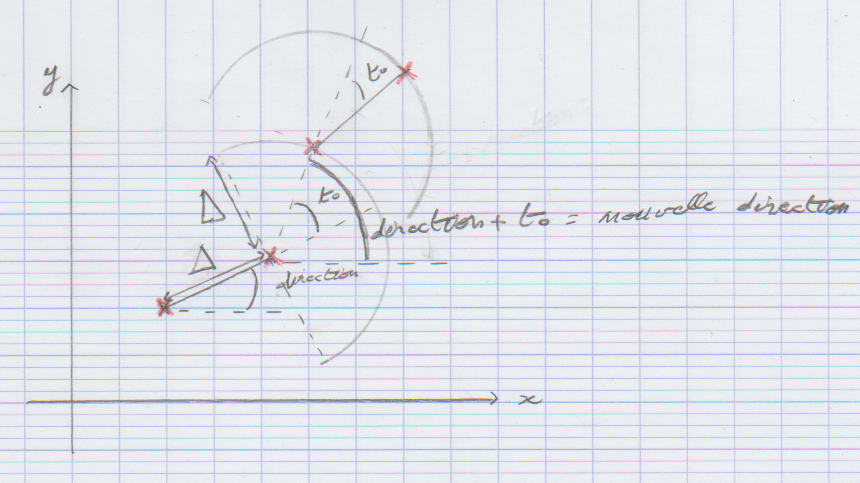


<center> Schéma du processus </center>

*direction* : variable qui stocke la direction (angle) du demi-cercle pour la dichotomie.  
*t0* : variable qui stocke la valeur de l'angle obtenue par dichotomie.  
En additionnant t0 avec la direction précédente, on obtient la nouvelle direction.

Remarque : La restriction de la dichotomie à un demi-cercle seulement, dans la direction opposée à celle formée par le point précédent et celui d'avant, assure que l'on ne revient pas en arrière, sur les mêmes points. 

In [51]:
# Une dichotomie sur une fonction : 
def dichotomie(f,c,a,b,eps = 2**(-26)):
    def h(t):
        return(f(t)-c)   
    while (b-a) > eps:
        k = (a+b)/2
        if h(a)*h(k) < 0:
            b = k
        else:
            a = k
    return(a)


def simple_contour_2(f, c = 0.0, delta = 0.01): 
    x,y = [],[]
    direction = 0
    if find_seed(f,c) != None:
        t = find_seed(f,c)
        x.append(0.0)
        y.append(t)
        t0 = 0
        while (0<=x[-1]<=1) and (0<=y[-1]<=1) and np.pi/2 - t0 >= 2**(-26): 
        # le dernier test permet de quitter la boucle si y a pas de solution à la dichotomie : la ligne de niveau s'arrête.
            x0 = x[-1] 
            y0 = y[-1]
            def h(t):
                return(f(x0+delta*np.cos(t+direction),y0+delta*np.sin(t+direction)))
            t0 = dichotomie(h,c,-np.pi/2,np.pi/2,2**(-26))
            direction += t0
            x.append(x0 + delta*np.cos(direction))
            y.append(y0 + delta*np.sin(direction))
        return x,y
    return [],[]

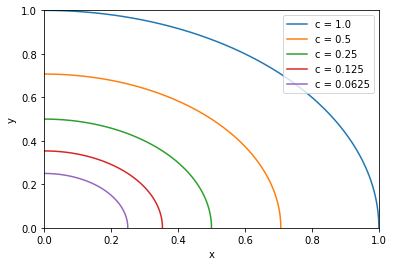

In [52]:
# Test sur la fonction quadratique, sur [0,1].
for i in range(5):
    x_i,y_i = simple_contour_2(quad, (1/2)**i)
    plt.plot(x_i,y_i, label = f"c = {(1/2)**i}")
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Commentaires:  
  
$\triangleright$ Cet algorithme ne marche pas pour tout type de fonctions, puisque l'on peut imaginer des fonctions avec des lignes de niveau formant des angles aigus : le point suivant ne sera alors pas dans le demi-cercle inspecté. On peut alors effectuer la dichotomie sur une portion plus grande du cercle - *mais jamais tout le cercle, pour ne pas revenir en arrière* - mais on pourra toujours construire des fonctions qui ne marchent pas, pour une portion donnée.
  
Cependant, pour une fonction donnée, on peut donc construire une portion de cercle à inspecter, qui marchera. 
  
De plus, on peut aussi ajuster le pas $\Delta$ et le choisir faible pour gérer ces problèmes.

$\triangleright$ Le dernier test de la boucle while permet d'arrêter le tracé si jamais la ligne de niveau s'arrête brusquement. En effet, le code de la fonction dichotomie tel que nous l'avons implémenté ne prévoit pas d'erreur s'il n'y a pas de solution. Cependant, si c'est le cas, alors on aura $h(a).h(k) > 0$ à chaque itération, et alors c'est $a$ qui prendra une valeur se rapprochant de $b$ à chaque étape, jusqu'à ce que $b-a < eps$, $b$ n'ayant jamais été modifié.  

Comme on peut prendre $eps$ aussi petit que voulu, on peut alors considérer qu'en pratique, si on a effectivement $a$ modifié à chaque étape, c'est bien parce qu'il n'y a pas de solution, et non que la solution se trouve dans l'intervalle $]b,b+eps[$.

### Contour complexe :

On suppose maintenant que $f$ n'est plus définie sur $[0,1]^2$, mais sur un rectangle borné de $\mathbb{R}^2$.  
On généralise les fonctions précédentes et on divise le domaine en carrés pour les appliquer.

* Les fonctions de recherche de seed des quatres côtés :

In [53]:
def find_seed_gauche(f, c, xmin, ymin, ymax, eps = 2**(-26)):
    def h(t):
        return(f(xmin,t)-c)
    if h(ymin)*h(ymax) > 0:
        return None
    else:
        i,j = ymin,ymax
        while (j-i) > eps:
            k = (i+j) / 2
            if h(k)*h(j) > 0:
                j = k
            else:
                i = k
    return i

def find_seed_droite(f, c, xmax, ymin, ymax, eps = 2**(-26)):
    def h(t):
        return(f(xmax,t)-c)
    if h(ymin)*h(ymax) > 0:
        return None
    else:
        i,j = ymin,ymax
        while (j-i) > eps:
            k = (i+j) / 2
            if h(k)*h(j) > 0:
                j = k
            else:
                i = k
    return i
    
def find_seed_bas(f, c, xmin, xmax, ymin, eps = 2**(-26)):
    def h(t):
        return(f(t,ymin)-c)
    if h(xmin)*h(xmax) > 0:
        return None
    else:
        i,j = xmin,xmax
        while (j-i) > eps:
            k = (i+j) / 2
            if h(k)*h(j) > 0:
                j = k
            else:
                i = k
    return i

def find_seed_haut(f, c, xmin, xmax, ymax, eps = 2**(-26)):
    def h(t):
        return(f(t,ymax)-c)
    if h(xmin)*h(xmax) > 0:
        return None
    else:
        i,j = xmin,xmax
        while (j-i) > eps:
            k = (i+j) / 2
            if h(k)*h(j) > 0:
                j = k
            else:
                i = k
    return i

Remarque : On peut éviter de coder 4 fonctions, en transformant une même fonction pour l'adapter, mais le résultat sera le même.

**Méthode #1: Gradient**

* Une fonction *simple_contour_annexe* adaptée aux nouveaux contours variables, et à la recherche de seed sur 4 côtés : 

In [54]:
# Distance pour comparer
def d(x,y,z,t):
    return (x-z)**2 + (y-t)**2


def simple_contour_annexe(f, xmin, xmax, ymin, ymax, c, delta):
    lx, ly= [], []
    x,y = [],[]
    # Ici, une disjonction de cas sur le bord, donc 4 blocs assez similaires.
    if find_seed_gauche(f, c, xmin, ymin, ymax) != None:
        t = find_seed_gauche(f, c, xmin, ymin, ymax)
        x.append(xmin)
        y.append(t)
        [a,b] = grad(f,xmin,t)
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax):
            x_0,y_0 = x[-1],y[-1]
            if b !=0:
                if len(x)>=2:
                    xp, yp = x[-2],y[-2]
                    x1,x2 = x_0 + delta/np.sqrt((1 + (a/b)**2)), x_0 - delta/np.sqrt((1 + (a/b)**2))
                    y1,y2 = -a/b*(x1 - x_0) + y_0, -a/b*(x2 - x_0) + y_0
                    if d(x1,y1,xp,yp) >= d(x2,y2,xp,yp):
                        x.append(x1)
                        y.append(y1)
                    else:
                        x.append(x2)
                        y.append(y2)
                else:
                    x.append(x_0 + delta/np.sqrt((1 + (a/b)**2)))
                    y.append(-a/b*(x[-1] - x_0) + y_0)
            else:
                x.append(x_0)
                y.append(y_0 + delta)
            [a,b] = grad(f,x[-1],y[-1])
        lx, ly = x, y
    x, y = [],[]
    if find_seed_droite(f, c, xmax, ymin, ymax) != None:
        t = find_seed_droite(f, c, xmax, ymin, ymax)
        x.append(xmax)
        y.append(t)
        [a,b] = grad(f,xmax,t)
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax):
            x_0,y_0 = x[-1],y[-1]
            if b !=0:
                if len(x)>=2:
                    xp, yp = x[-2],y[-2]
                    x1,x2 = x_0 + delta/np.sqrt((1 + (a/b)**2)), x_0 - delta/np.sqrt((1 + (a/b)**2))
                    y1,y2 = -a/b*(x1 - x_0) + y_0, -a/b*(x2 - x_0) + y_0
                    if d(x1,y1,xp,yp) >= d(x2,y2,xp,yp):
                        x.append(x1)
                        y.append(y1)
                    else:
                        x.append(x2)
                        y.append(y2)
                else:
                    x.append(x_0 + delta/np.sqrt((1 + (a/b)**2)))
                    y.append(-a/b*(x[-1] - x_0) + y_0)
            else:
                x.append(x_0)
                y.append(y_0 + delta)
            [a,b] = grad(f,x[-1],y[-1])
        lx, ly = lx + x, ly + y
    x, y = [],[]
    if find_seed_bas(f, c, xmin, xmax, ymin) != None:
        t = find_seed_bas(f, c, xmin, xmax, ymin)
        x.append(t)
        y.append(ymin)
        [a,b] = grad(f,t,ymin)
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax):
            x_0,y_0 = x[-1],y[-1]
            if b !=0:
                if len(x)>=2:
                    xp, yp = x[-2],y[-2]
                    x1,x2 = x_0 + delta/np.sqrt((1 + (a/b)**2)), x_0 - delta/np.sqrt((1 + (a/b)**2))
                    y1,y2 = -a/b*(x1 - x_0) + y_0, -a/b*(x2 - x_0) + y_0
                    if d(x1,y1,xp,yp) >= d(x2,y2,xp,yp):
                        x.append(x1)
                        y.append(y1)
                    else:
                        x.append(x2)
                        y.append(y2)
                else:
                    x.append(x_0 + delta/np.sqrt((1 + (a/b)**2)))
                    y.append(-a/b*(x[-1] - x_0) + y_0)
            else:
                x.append(x_0)
                y.append(y_0 + delta)
            [a,b] = grad(f,x[-1],y[-1])
        lx, ly = lx + x, ly + y
    x, y = [],[]
    if find_seed_haut(f, c, xmin, xmax, ymax) != None:
        t = find_seed_haut(f, c, xmin, xmax, ymax)
        x.append(t)
        y.append(ymax)
        [a,b] = grad(f,t,ymax)
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax):
            x_0,y_0 = x[-1],y[-1]
            if b !=0:
                if len(x)>=2:
                    xp, yp = x[-2],y[-2]
                    x1,x2 = x_0 + delta/np.sqrt((1 + (a/b)**2)), x_0 - delta/np.sqrt((1 + (a/b)**2))
                    y1,y2 = -a/b*(x1 - x_0) + y_0, -a/b*(x2 - x_0) + y_0
                    if d(x1,y1,xp,yp) >= d(x2,y2,xp,yp):
                        x.append(x1)
                        y.append(y1)
                    else:
                        x.append(x2)
                        y.append(y2)
                else:
                    x.append(x_0 + delta/np.sqrt((1 + (a/b)**2)))
                    y.append(-a/b*(x[-1] - x_0) + y_0)
            else:
                x.append(x_0)
                y.append(y_0 + delta)
            [a,b] = grad(f,x[-1],y[-1])
        lx, ly = lx + x, ly + y 
        
    return (lx,ly)

* La fonction *contour* finale : 

In [55]:
def contour(f, xc = [0.0,1.0], yc = [0.0,1.0], c = 0.0, delta = 0.01):
    xs, ys = [], []
    n, m = len(xc), len(yc)
    for i in range(n-1):
        for j in range(m-1):
            xmin = xc[i]
            xmax = xc[i+1]
            ymin = yc[j]
            ymax = yc[j+1]
            lx, ly = simple_contour_annexe(f,xmin,xmax,ymin,ymax,c,delta)
            xs.append(lx)
            ys.append(ly)
    for x,y in zip(xs,ys):
        plt.plot(x,y,'.',color='r', markersize=2)

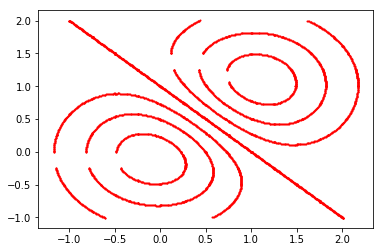

In [56]:
# Test avec la fonction l(x,y)

xc = [-2.0,-1.75,-1.5,-1.25,-1.0,-0.75,-0.50,-0.25,0.0,0.25,0.5,0.75,1.0,1.25,1.50,1.75,2.0,2.25,2.50,2.75,3.0]
yc = [-1.0,-0.75,-0.50,-0.25,0.0,0.25,0.5,0.75,1.0,1.25,1.50,1.75,2.0]

contour(l,xc,yc,0.0)
contour(l,xc,yc,0.5)
contour(l,xc,yc,1.0)
contour(l,xc,yc,1.5)  
contour(l,xc,yc,-0.5)
contour(l,xc,yc,-1.0)
contour(l,xc,yc,-1.5)

Commentaires:  
$\triangleright$ On observe deux zones où la ligne de niveau n'a pas été tracée, ce qui provient probablement d'un problème ponctuel dans la méthode ou dans le code, que nous n'avons pas réussi à déterminer. Le reste de la figure est conforme à la figure réelle.  
$\triangleright$ La complexité pratique reste assez faible pour une division en $20 \times 12 = 240$ carrés : de l'ordre de 10 secondes.

**Méthode #2: Dichotomie sur cercles**


* A nouveau, une fonction *simple_contour_annexe_2* avec la méthode de la dichotomie sur les cercles.

In [57]:
def simple_contour_annexe_2(f, xmin, xmax, ymin, ymax, c, delta):
    x,y = [],[]
    lx,ly = [],[]
    direction = 0
    # Ici, une disjonction de cas sur le bord, donc 4 blocs assez similaires.
    if find_seed_gauche(f, c, xmin, ymin, ymax) != None:
        t = find_seed_gauche(f, c, xmin, ymin, ymax)
        x.append(xmin)
        y.append(t)
        t0 = 0
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax) and (np.pi/2 - t0 >= 2**(-26)): 
            # le dernier test permet de quitter la boucle si y a pas de solution à la dichotomie : la ligne de niveau s'arrête.
            x0 = x[-1] 
            y0 = y[-1]
            def h(t):
                # fonction f sur le cercle autour de (x0,y0)
                return(f(x0+delta*np.cos(t+direction),y0+delta*np.sin(t+direction)))
            t0 = dichotomie(h,c,-np.pi/2,np.pi/2,2**(-26))
            direction += t0
            x.append(x0 + delta*np.cos(direction))
            y.append(y0 + delta*np.sin(direction))
        lx, ly = x, y
    x,y = [],[]
    direction = np.pi
    if find_seed_droite(f, c, xmax, ymin, ymax) != None:
        t = find_seed_droite(f, c, xmax, ymin, ymax)
        x.append(xmax)
        y.append(t)
        t0 = 0
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax) and (np.pi/2 - t0 >= 2**(-26)): 
            x0 = x[-1]
            y0 = y[-1]
            def h(t):
                return(f(x0+delta*np.cos(t+direction),y0+delta*np.sin(t+direction)))
            t0 = dichotomie(h,c,-np.pi/2,np.pi/2,2**(-26))
            direction += t0
            x.append(x0 + delta*np.cos(direction))
            y.append(y0 + delta*np.sin(direction))
        lx, ly= lx + x, ly + y
    x,y = [],[]
    direction = np.pi/2
    if find_seed_bas(f, c, xmin, xmax, ymin) != None:
        t = find_seed_bas(f, c, xmin, xmax, ymin)
        x.append(t)
        y.append(ymin)
        t0 = 0
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax) and (np.pi/2 - t0 >= 2**(-26)): 
            x0 = x[-1] 
            y0 = y[-1]
            def h(t):
                return(f(x0+delta*np.cos(t+direction),y0+delta*np.sin(t+direction)))
            t0 = dichotomie(h,c,-np.pi/2,np.pi/2,2**(-26))
            direction += t0
            x.append(x0 + delta*np.cos(direction))
            y.append(y0 + delta*np.sin(direction))
        lx, ly = lx + x, ly + y
    x,y = [],[]
    direction = -np.pi/2
    if find_seed_haut(f, c, xmin, xmax, ymax) != None:
        t = find_seed_haut(f, c, xmin, xmax, ymax)
        x.append(t)
        y.append(ymax)
        t0 = 0
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax) and (np.pi/2 - t0 >= 2**(-26)):
            x0 = x[-1]
            y0 = y[-1]
            def h(t):
                return(f(x0+delta*np.cos(t+direction),y0+delta*np.sin(t+direction)))
            t0 = dichotomie(h,c,-np.pi/2,np.pi/2,2**(-26))
            direction += t0
            x.append(x0 + delta*np.cos(direction))
            y.append(y0 + delta*np.sin(direction))
        lx, ly = lx + x, ly + y
    return (lx,ly)

* La fonction *contour_2* finale :

In [58]:
def contour_2(f, xc = [0.0,1.0], yc = [0.0,1.0], c = 0.0, delta = 0.01):
    xs, ys = [], []
    n, m = len(xc), len(yc)
    for i in range(n-1):
        for j in range(m-1):
            xmin = xc[i]
            xmax = xc[i+1]
            ymin = yc[j]
            ymax = yc[j+1]
            lx,ly = simple_contour_annexe_2(f,xmin,xmax,ymin,ymax,c,delta)
            xs.append(lx)
            ys.append(ly)
    for x,y in zip(xs,ys):
        plt.plot(x,y, color = 'r')

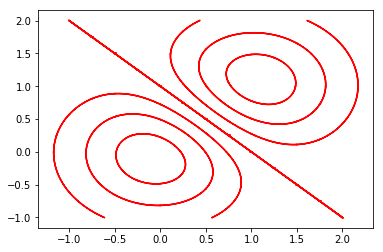

In [59]:
# Test avec la fonction l(x,y)

xc = [-2.0,-1.75,-1.5,-1.25,-1.0,-0.75,-0.50,-0.25,0.0,0.25,0.5,0.75,1.0,1.25,1.50,1.75,2.0,2.25,2.50,2.75,3.0]
yc = [-1.0,-0.75,-0.50,-0.25,0.0,0.25,0.5,0.75,1.0,1.25,1.50,1.75,2.0]

contour_2(l,xc,yc,0.0)
contour_2(l,xc,yc,0.5)
contour_2(l,xc,yc,1.0)
contour_2(l,xc,yc,1.5)  
contour_2(l,xc,yc,-0.5)
contour_2(l,xc,yc,-1.0)
contour_2(l,xc,yc,-1.5)

Commentaires:    
$\triangleright$ Cette fois-ci, le résultat obtenu est bien celui que l'on recherchait : L'algorithme fonctionne pour cette fonction.  
$\triangleright$ La complexité pratique est proche de celle de la méthode #1, de l'ordre d'une dizaine de secondes, pour une même division en $20 \times 12 = 240$ carrés.  

### Conclusion :

  Cette étude nous a permis d'élaborer deux algorithmes de lignes de niveaux, basés sur des principes différents: 
    
    
  $\triangleright$ Méthode du gradient : 
   - Effective seulement pour les points où le gradient est non nul.  On peut imaginer des fonctions avec une ligne de niveau constituée d'extrema, qui ne pourraît alors être obtenue.
   - Donne deux points à chaque itération, il est nécessaire d'effectuer un choix : nous l'avons traité en prenant le point s'éloignant le plus des points précédents.
   - Solution pas exacte avec *contour*, ce qui est peut-être causé par une erreur ponctuelle dans le code.
  
$\triangleright$ Méthode par dichotomie sur les cercles : 
   - Problèmes possibles liés à la restriction de la dichotomie à un demi-cercle. Mais pour une fonction donnée, on peut définir une proportion de cercle adéquate, et ainsi développer une fonction qui marche.
   - Fournit une solution avec *contour* proche de la théorie et efficace.
  
Ainsi, la pratique nous pousse à retenir la seconde solution, plus efficace *a priori* (du moins pour les types de fonctions testés).